# Tutorial Modelos de Ensamble tipo XGBoost

En este tutorial aplicaremos un modelo de ensamble tipo XGBoost a una serie de precios. Este tutorial se enfoca a generar una estructura en los datos que permita un pronóstico hacia adelante. Es decir, buscamos generar una estructura de ensamble a un conjunto de datos condicionados a eventos pasados, para luego generar un pronóstico futuro de los mismos. La serie por tanto genera una estructura de ensamble entrenada en una sección correspondiente de entrenamiento para luego generar un pronóstico hacia adelante en una estructura de datos transformada y mediante un modelo con refinamiento de parámetros.

**Contenido**
1. [Importación de librerías requeridas](#2)
1. [Importación de datos financieros](#3)
1. [Visualización de datos financieros](#4)
1. [Preprocesamiento de datos](#5)
1. [Partición de datos en entrenamiento y prueba](#6)
1. [Visualización conjunto de entrenamiento y prueba](#7)
1. [.Regresión con XGBoost ](#14)
1. [Creación Forecaster con XGBoost](#15)
1. [Pronóstico en datos de entrenamiento y determinación de error](#16)
1. [Refinamiento de los hiperparámetros](#17)
1. [Aplicación del modelo óptimo a serie completa](#18)
1. [Generación del pronóstico hacia adelante](#19)
1. [Visualización de resultados](#20)

<a id="2"></a> <br>
### 1. Importación de librerías requeridas

Importa las siguientes librerías para desarrollar este tutorial:

In [1]:
pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 13.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Esta es requerida para importar los datos financieros
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.7 MB/s eta 0:00:00


In [3]:
# Manipulación datos
import numpy as np
import pandas as pd

from numpy import array
#from keras.models import Sequential
#from keras.layers import Dense
from numpy import asarray
from pandas import DataFrame
from pandas import concat

# Gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import pyplot
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelación y pronóstico
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


#XGBoost:
# Modelado y Forecasting
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
##Regressor:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


from joblib import dump, load


from datetime import datetime
from math import sqrt
# Configuración de warnings:
import warnings
# warnings.filterwarnings('ignore')

In [4]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
##Si tienes problemas para descarlar pandas datareader, puedes probar la siguiente linea:
#!pip install git+https://github.com/pydata/pandas-datareader.git

<a id="3"></a> <br>
### 2. Importación de datos financieros

Establecemos primeramente la fecha de inicio y fin, así como el activo o los activos de interés. En este ejemplo, emplearemos únicamente un activo, pero dejo desactivados otros ejemplos de stocks (stks), índices (idx), monedas (ccy) como ejemplos de otros activos.

In [6]:
#Establecemos las fechas de consulta:
start = '2015-01-01'
end = '2022-07-29'
#ticker = 'AAPL'
#data = pdr.get_data_yahoo(ticker, start, end)['Adj Close']
amzn='AMZN'
#stks_tickers = ['AAPL','IBM', 'GOOGL']
#idx_tickers = ['SPY', '^DJI', '^VIX']
#ccy_tickers = ['JPY=X', 'GBPUSD=X']

In [7]:
#Una vez declarado el ticker, pedimos a través de la función de pandas data reader (pdr), bajar lso datos de la fuente de yahoo finance.
amzn = pdr.get_data_yahoo("AMZN", start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [8]:
amzn.head()

Date
2015-01-02    15.4260
2015-01-05    15.1095
2015-01-06    14.7645
2015-01-07    14.9210
2015-01-08    15.0230
Name: Close, dtype: float64

In [9]:
#Pasamos a data frame los datos
dt= pandas.DataFrame(amzn)
dt.head()

,Close
Date,
2015-01-02,15.4260
2015-01-05,15.1095
2015-01-06,14.7645
2015-01-07,14.9210
2015-01-08,15.0230


In [10]:
#Identificamos la longitud de la serie
len(dt)

1906

In [11]:
#Damos un vistazo a los datos
dt.head()
dt.tail()
data = dt.rename(columns={'Close': 'y'})
data

,y
Date,
2015-01-02,15.426000
2015-01-05,15.109500
2015-01-06,14.764500
2015-01-07,14.921000
2015-01-08,15.023000
...,...
2022-07-22,122.419998
2022-07-25,121.139999
2022-07-26,114.809998


<a id="4"></a> <br>
### 3. Visualización de datos financieros

Para visualizar la serie de tiempo, debemos importar la librería de matplotlib.

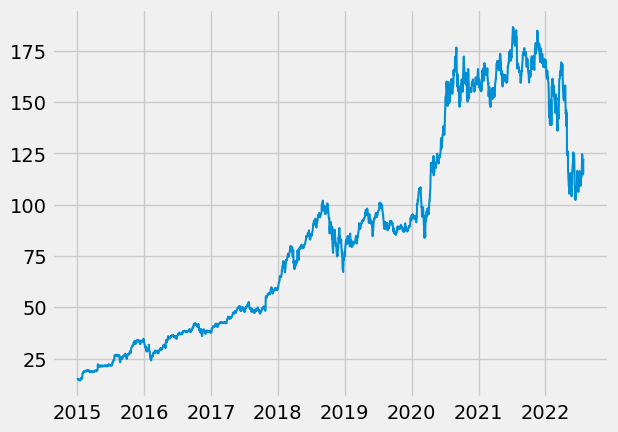

In [12]:
#Una vez llamada la librería, graficamos la serie dt.
import matplotlib.pyplot as plt
plt.plot(dt)

<a id="5"></a> <br>
### 4. Preprocesamiento de datos

En esta parte, debemos primero convertir nuestros datos tipo dataframe a un objeto de pandas con fecha. Igualmente, la parte de valores de la serie, como el precio, lo pasamos a un tipo NumPy array que facilitará el procesamiento. 

In [13]:
#Ahora, pasamos el data frame a un objeto de tiempo de pandas.
dataindex= pd.to_datetime(data.index)
dataindex

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-07-15', '2022-07-18', '2022-07-19', '2022-07-20',
               '2022-07-21', '2022-07-22', '2022-07-25', '2022-07-26',
               '2022-07-27', '2022-07-28'],
              dtype='datetime64[ns]', name='Date', length=1906, freq=None)

<a id="6"></a> <br>
### 5. Partición de datos en entrenamiento y prueba

En esta sección, partimos el conjunto de datos de pueba y de entrenamiento. Podemos tomar una referencia general de una proporción del 80/20 de la serie.

In [14]:
#Especificamos los últimos datos que servirán para la parte de testing o capacidad predictiva del modelo.
steps = 36
#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
data_train = data[:-steps]
data_test  = data[-steps:]

#Así también para las fechas:
date_train = dataindex[:-steps]
date_test = dataindex[-steps:]

In [15]:
#Vemos los datos para las fechas que nos sirven para las gráficas
date_train
#date_test  #Igualmente para visualizarlos

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26',
               '2022-05-27', '2022-05-31', '2022-06-01', '2022-06-02',
               '2022-06-03', '2022-06-06'],
              dtype='datetime64[ns]', name='Date', length=1870, freq=None)

In [16]:
#Imprimimos la longitud de ambos conjuntos de datos:
print(len(data_train))
print(len(data_test))

1870
36


<a id="7"></a> <br>
### 6. Visualización conjunto de entrenamiento y prueba

Revisemos la partición de la serie de tiempo en los conjuntos de entrenamiento y prueba.

In [17]:
#Graficamos la serie anterior, aunando el valor del pronóstico.
trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Data'
)

trace2 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'test'
)

layout = go.Layout(
    title = "Amzn Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

# Regresión con XGBoost 

En esta sección aplicaremos el modelo de ensamble para la regresión empleando el algoritmo XGBoost. Ya que se trata de la misma serie, retomaremos los mismos datos de entrenamiento y prueba. Es importante mencionar que la función de refinamiento es en este modelo mucho más tardada que el Random Forest. El proceso general similar al proceso de Random Forest, donde una vez obtenidos los parámetros del refinamiento, se vuelve a aplicar la función de regresión sobre la serie completa, para finalmente generar el pronóstico futuro.

<a id="15"></a> <br>
### 7. Creación Forecaster con XGBoost

En esta sección desarrollaremos un modelo de ensable tipo XGBoost a la misma serie de datos. 

In [18]:
# Creamos y entrenamos el modelo de XGB con la función de estructura de datos generada a través de la función Forecaster, creando ventanas de 10 días. En los resultados del modelo, podemos ver las condiciones generales estándares de configuración de los parámetros.
# ==============================================================================
### Puedes intentar entrenar otros metodos de boosting como: LGBMRegressor o CatBoostRegressor
forecaster_xgb = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 10
                )

forecaster_xgb.fit(y=data_train['y'])
forecaster_xgb

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 1869] 
Training index 

<a id="16"></a> <br>
### 8. Pronóstico en datos de entrenamiento y determinación de error

Ahora revisemos el rendimiento del modelo usando una medida de error.

In [19]:
# Pronóstico, en este caso elegimos una ventana de 36 días.
# ==============================================================================
steps = 36
predictions_xgb= forecaster_xgb.predict(steps=steps)
predictions_xgb.head(5)

10    121.170578
11    120.736916
12    118.102402
13    119.759621
14    120.518753
Name: pred, dtype: float64

In [21]:
# Determinamos el error de pronóstico:
# ==============================================================================
error_mse_xgb = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions_xgb
            )

print(f"Test error (mse): {error_mse_xgb}")
RMSE = sqrt(error_mse_xgb)
print(f"Test error (rmse): {RMSE}")

Test error (mse): 80.10451807594251
Test error (rmse): 8.95011274096268


<a id="17"></a> <br>
### 9. Refinamiento de los hiperparámetros

En esta sección aplicamos la función de search-grid a los resultados del modelo con parámetros iniciales. Este proceso lleva un par de horas en realizarse. Recordar que se aplica a la sección de entrenamiento que es donde se aplicó el modelo inicial de regresión.

In [22]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


resultados_grid_xgb = grid_search_forecaster(
        forecaster         = forecaster_xgb,
        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )


Number of models compared: 48.


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [31:19<00:00, 469.86s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 141.3320222879125



In [57]:
# Resultados Grid Search
# ==============================================================================
resultados_grid_xgb.head(10)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
42,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",141.332022,0.10,3.0,100.0
44,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",147.548896,0.10,5.0,100.0
37,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",154.521446,0.01,3.0,500.0
43,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",156.053454,0.10,3.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",160.164217,0.10,3.0,100.0
46,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",165.153898,0.10,10.0,100.0
45,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",165.293549,0.10,5.0,500.0
39,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",169.320759,0.01,5.0,500.0
47,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",169.652059,0.10,10.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",172.992689,0.10,3.0,500.0


Como podemos observar, los resultados del grid search nos entregarán la mejor combinación del modelo en cuanto a los parámetros a suministrar. Es importante notar que la métricas de error no son comparables con aquellos del punto en 8, ya que los métodos de cálculo son diferentes. Estos resultados fueron mediante backtesting mientras que el anterior fue obtenido directamente sobre la sección de prueba vs los datos de pronóstico.

<a id="18"></a> <br>
### 10. Aplicación del modelo óptimo a serie completa

Una vez obtenidos los parámetros óptimos, configuramos el modelo de ensamble para que genere la regresión a la serie completa.

In [47]:
# Creamos y entrenamos el modelo de XGB con la función de estructura de datos generada a través de la función Forecaster, y condiciones del refinamiento, creando ventanas de 10 días:
forecaster_xgb = ForecasterAutoreg(
                regressor = XGBRegressor(learning_rate=0.10, n_estimators=100, random_state=123),
                lags = 10
                )

forecaster_xgb.fit(y=data['y'])
#forecaster_xgb

In [48]:
# Podemos imprimir la importancia de los rezagos
forecaster_xgb.get_feature_importance()

,feature,importance
0,lag_1,0.665600
1,lag_2,0.221225
2,lag_3,0.011891
3,lag_4,0.001209
4,lag_5,0.072868
5,lag_6,0.007905
6,lag_7,0.000330
7,lag_8,0.000487
8,lag_9,0.012364
9,lag_10,0.006121


<a id="19"></a> <br>
### 11. Generación del pronóstico hacia adelante

Con el modelo final, podemos así generar el pronóstico futuro o hacia adelante.

In [52]:
# Pronóstico, en este caso elegimos una ventana de 10 días.
# ==============================================================================
steps = 10
predictions_xgb_fwd= forecaster_xgb.predict(steps=steps)
predictions_xgb_fwd.head(5)

10    123.167671
11    121.985474
12    122.571182
13    123.714355
14    123.006668
Name: pred, dtype: float64

In [53]:
## Generamos las fechas a dichos pronósticos mediante la función de pandas date_range:
fin = data_test.index.max()   #Partimos de la fecha máxima de la sección de prueba, hacia adelante.
fwd_dates = pd.date_range(fin, periods=10).tolist()
fwd_dates

[Timestamp('2022-07-28 00:00:00', freq='D'),
 Timestamp('2022-07-29 00:00:00', freq='D'),
 Timestamp('2022-07-30 00:00:00', freq='D'),
 Timestamp('2022-07-31 00:00:00', freq='D'),
 Timestamp('2022-08-01 00:00:00', freq='D'),
 Timestamp('2022-08-02 00:00:00', freq='D'),
 Timestamp('2022-08-03 00:00:00', freq='D'),
 Timestamp('2022-08-04 00:00:00', freq='D'),
 Timestamp('2022-08-05 00:00:00', freq='D'),
 Timestamp('2022-08-06 00:00:00', freq='D')]

<a id="20"></a> <br>
### 12. Visualización de resultados

En esta sección podemos visualizar los resultados del XGBoost. Esto se confirma con los resultados obtenidos en los métricos de error del proceso de backtesting.

In [55]:
#Graficamos la serie anterior, aunando el valor del pronóstico.

trace3 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'Test'
)

trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Train'
    )

trace5 = go.Scatter(
    x = fwd_dates,
    y = predictions_xgb_fwd,
    mode = 'lines',
    name = 'Pronóstico Futuro XGB'
    )
layout = go.Layout(
    title = "Amzn Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace3, trace5], layout=layout)
fig.show()

En este tutorial aprendiste un proceso para la generación de pronósticos futuros de una serie financiera mediante modelos de ensamble tipo Boosting. En el proceso, reiteramos la importancia de transformar los datos de una serie de tiempo en una estructura de datos que permiten generar secuencias de entrenamiento y pronóstico de la serie con base en datos históricos. Este proceso se debe hacer especialmente cuando deseamos generar un pronóstico hacia adelante en series de tiempo. Dicho proceso es muy similar al que se emplea cuando aplicamos un problema supervisado tal como una regresión lineal o modelos regresivos, donde se generan los retrasos o lags de la serie y cuyos features ingresan al modelo de regresión. En este caso, se crea una estructura en la cual se puede emplear para entrenar un modelo de ensamble cuyo proceso puede ser tedioso. Para ello, existen funciones que ayudan es esa tarea, en el caso particular de este tutorial, empleamos la función de Forecaster Autoregressor que crea la estructura de datos y aplica el modelo de y XGBoost con los parámetros suministrados. Una vez obtenido el modelo se genera el pronóstico futuro especificando la serie a emplear.

Referencias: 

 Este tutorial emplea la función ForecasterAutoreg de la paquetería skforecast (https://pypi.org/project/skforecast/). 
 
 Ceballos, F. 2019. Stacking classifiers for higher predictive performance. Towards Data Science. Retrieved from: https://towardsdatascience.com/stacking-classifiers-for-higher-predictive-performance-566f963e4840 